# The effect of the _"Black Lives Matter"_ movement on the arrestation of African American people in L.A.

___

### Context _(TODO)_

In July 2013, after the acquittal of the neighborhood watch coordinator George Zimmerman in the shooting of the African American Trayvin Martin, the hashtag #BlackLivesMatter appeared for the first time on social media. This event launched the creation of the now worldwide known movement "Black Lives Matter" that aims to advocate against violence inflicted on Black communities.

The purpose of our study is to observe the effect of the creation of the Black Lives Matter social movement on the arrests of African Americans. More specifically, we investigate if the creation of the movement induced a change in the trend of the overall arrests of African American people. The evolution of the trend of arrests of the other races is also explored as a comparison and the difference between male and female African Americans is analysed as well for complementary information.

### The data 


For our analysis, we will work on [Los Angeles Crime & Arrest Data](https://www.kaggle.com/cityofLA/los-angeles-crime-arrest-data?select=crime-data-from-2010-to-present.csv) which is provided by the City of Los Angeles. This dataset maps all the arrests that have been performed in LA between January 2010 and July 2019.

This dataset contains the following main variables:

- `Report ID`: ID of the arrest
- `Arrest date`: date of the arrest
- `Time`: an integer with the time of the arrest in 24 hour
- `Area ID`: refers to the geographic areas within the department
- `Area Name`: a string with the name of the area
- `Reporting District`: an integer that represents a sub-area within the geographic area
- `Age`: integer for the age of the arrested person
- `Sex code`: a string with F for Female and M for Male
- `Descent Code`: a string for each origin (among them, W stands for white, B for black, H for Hispanic/Latin/Mexican and O for other) 
- `Charge Group Code`: an integer corresponding to a category of arrest charge

Other variables are also present but will not be studied in the analysis:

- `Charge Group Code`
- `Charge Group Description`
- `Arrest Type Code`
- `Charge`
- `Charge Description`
- `Address`
- `Cross Street`
- `Location`
- `Zip Codes`
- `Census Tracts`
- `Precinct Boundaries`
- `LA Specific Plans`
- `Council Districts`
- `Neighborhood Councils (Certified`



___

## Data wrangling

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
import pylab
from scipy import stats
from matplotlib.lines import Line2D
from statsmodels.graphics.gofplots import qqplot

arrest_data = pd.read_csv('arrest-data-from-2010-to-present.csv', error_bad_lines = False)

Now that we've loaded our data, let's have a sneak peek at our dataframe.

In [2]:
arrest_data.head()

,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,...,Charge Description,Address,Cross Street,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,5666847,2019-06-22T00:00:00.000,1630.0,14,Pacific,1457,44,M,W,24.0,...,VANDALISM,12300 CULVER BL,NaN,"{'latitude': '33.992', 'human_address': '{""add...",24031.0,918.0,1137.0,10.0,10.0,85.0
1,5666688,2019-06-22T00:00:00.000,1010.0,10,West Valley,1061,8,M,O,NaN,...,NaN,19000 VANOWEN ST,NaN,"{'latitude': '34.1687', 'human_address': '{""ad...",19339.0,321.0,1494.0,NaN,4.0,10.0
2,5666570,2019-06-22T00:00:00.000,400.0,15,N Hollywood,1543,31,F,O,22.0,...,DRUNK DRIVING ALCOHOL/DRUGS,MAGNOLIA AV,LAUREL CANYON BL,"{'latitude': '34.1649', 'human_address': '{""ad...",8890.0,205.0,1332.0,17.0,5.0,39.0
3,5666529,2019-06-22T00:00:00.000,302.0,17,Devonshire,1738,23,F,W,22.0,...,DRUNK DRIVING ALCOHOL/DRUGS,HAYVENHURST ST,N REGAN FY,"{'latitude': '34.2692', 'human_address': '{""ad...",19329.0,69.0,388.0,NaN,2.0,78.0
4,5666742,2019-06-22T00:00:00.000,1240.0,14,Pacific,1472,28,M,W,8.0,...,OBSTRUCT/RESIST EXECUTIVE OFFICER,6600 ESPLANADE ST,NaN,"{'latitude': '33.9609', 'human_address': '{""ad...",25075.0,937.0,241.0,10.0,10.0,16.0


For our analysis, it is not important to keep all columns. Only the ones regarding the race, the date of the arrest, the gender and the type of arrest (i.e. infraction or felony) are of interest to us.

In [3]:
#Picking the necessary columns and renaming them
arrest_data = arrest_data[['Arrest Date', 'Sex Code', 'Descent Code', 'Arrest Type Code']] \
                .rename(columns = {'Arrest Date' : 'Date', 'Sex Code': 'Gender', 'Descent Code': 'Race', 
                                   'Arrest Type Code': 'Arrest Type'})

#Converting dates to DateTime objects
arrest_data['Date'] = pd.to_datetime(arrest_data['Date'], errors='coerce')

#Verifying that no date is 'NaT' (Not a Time)
assert(arrest_data.Date.isnull().sum() == 0)

#Sanity checks
assert(datetime.datetime(2010,1,1) == min(arrest_data.Date))
assert(datetime.datetime(2019,6,22) == max(arrest_data.Date))

arrest_data.head()

,Date,Gender,Race,Arrest Type
0,2019-06-22,M,W,M
1,2019-06-22,M,O,O
2,2019-06-22,F,O,M
3,2019-06-22,F,W,M
4,2019-06-22,M,W,F


As we observe further below, the 4 most present races are:
- `H` for Hispanic/Latin/Mexican
- `B` for Black
- `W` for White
- `O` for Other

___

## Question 1

### _Since the creation of the Black Lives Matter movement, was there a change in the trend of the overall arrests of African American people in L.A. ?_

### 1.1. Differences between the races

Let's start by looking at the number of arrests per race, just to get an idea of what this looks like.

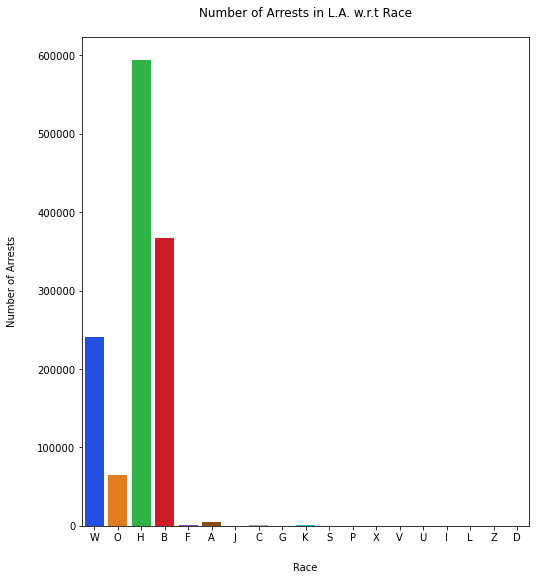

Number of White people arrested (2010-2019) : 240451
Percentage of total number of arrests: 18.842%

Number of Others people arrested (2010-2019) : 65426
Percentage of total number of arrests: 5.127%

Number of Hispanic people arrested (2010-2019) : 594321
Percentage of total number of arrests: 46.571%

Number of Black people arrested (2010-2019) :  367152
Percentage of total number of arrests: 28.77%



In [4]:
race_data = arrest_data[['Date', 'Race']] ############est ce qu'on a vraiment besoin de ce dataframe ?

fig = plt.figure(figsize = (8,9))
plot = sns.countplot(x = 'Race', data = arrest_data, palette = 'bright')
plt.title("Number of Arrests in L.A. w.r.t Race", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Race', labelpad = 20)
plt.show()

#Getting count for each race that has a high number of arrests (> 5%)
counts = arrest_data.Race.value_counts()
black_counts = counts['B'] #################Vraiment besoin de créer ces variables ?
hispanic_counts = counts['H']
white_counts = counts['W']
others_counts = counts['O']

print('Number of White people arrested (2010-2019) : ' + str(white_counts))
print('Percentage of total number of arrests: ' + str(round(white_counts/len(arrest_data)*100,3)) + "%\n")
print('Number of Others people arrested (2010-2019) : ' + str(others_counts))
print('Percentage of total number of arrests: ' + str(round(others_counts/len(arrest_data)*100,3)) + "%\n")
print('Number of Hispanic people arrested (2010-2019) : ' + str(hispanic_counts))
print('Percentage of total number of arrests: ' + str(round(hispanic_counts/len(arrest_data)*100,3)) + "%\n")
print('Number of Black people arrested (2010-2019) :  ' + str(black_counts))
print('Percentage of total number of arrests: ' + str(round(black_counts/len(arrest_data)*100,3)) + "%\n")

We can already see that there is quite a decrepency in the number of arrests with respect to the race.

Yet, the observed difference in the number of arrest per race could be due to the difference in the number of people of different race living in L.A. To asses this, we scale the data for the 3 main races (White, Black and Hispanic/Latin/Mexican) with respect to the race ratios in the population.

The actual race ratios in L.A. are the following:
- 28.5% of White
- 48.5% of Hispanic
- 8.9% of Black

We make the assumption that these ratios were approximately the same during the period we are analysing.

_Data are exctracted from the_ [US Census Bureau](https://www.census.gov/quickfacts/fact/table/US/PST045219_).

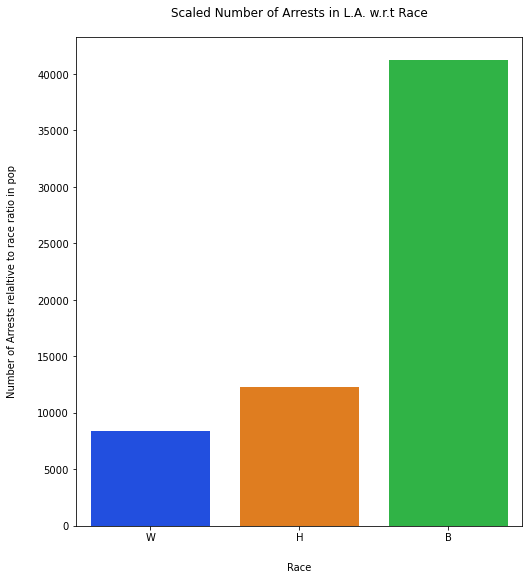

Hispanic people are arrested 1.452 more than white people.
Black people are arrested 4.89 more than white people.


In [5]:
ratios = [28.5, 48.5, 8.9]
scaled_counts = pd.DataFrame(counts[['W', 'H', 'B']] / ratios).rename(columns = {'Race':'Counts'})

fig = plt.figure(figsize = (8,9))
plot = sns.barplot(x = scaled_counts.index, y = 'Counts', data = scaled_counts, palette = 'bright')
plt.title("Scaled Number of Arrests in L.A. w.r.t Race", pad = 20)
plt.ylabel('Number of Arrests relaltive to race ratio in pop', labelpad = 20)
plt.xlabel('Race', labelpad = 20)
plt.show()

HW_ratio = scaled_counts.loc['H','Counts']/scaled_counts.loc['W','Counts']
BW_ratio = scaled_counts.loc['B','Counts']/scaled_counts.loc['W','Counts']
print("Hispanic people are arrested " + str(round(HW_ratio, 3)) + " more than white people.")
print("Black people are arrested " + str(round(BW_ratio, 3)) + " more than white people.")

These normalized values are not relevant in themselves as they are not meaningfull, but the comparison between them is highly relevant.

We can now say that hispanic people are more arrested than white people but mostly that black people are highly more arrested, almost 5 times more. This could be because of the uneven repartition of the races within the different social classes or because of a discrimination towards hispanic and mostly black people.

### 1.2. Non-model empirical findings: Average African American arrests before and after July 2013

Now, let's look at how the creation of the Black Lives Matter movement affected the number of arrests for Black people. We start by looking at "non-model" empirical findings, comparing the number of African Americans arrested before and after July, 2013 (from January 2010 to December 2016, i.e. 3.5 years before and after the creation of the black lives matter).

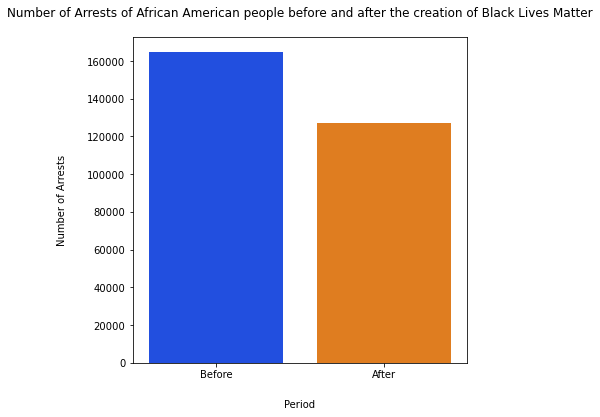

In [6]:
black_data = race_data[race_data['Race'] == 'B']
movement_creation_date = datetime.datetime(2013, 8, 1)
black_before_movement = black_data[black_data['Date'] < movement_creation_date].assign(Period = "Before")
black_after_movement = black_data[(black_data['Date'] >= movement_creation_date) & 
                                  (black_data['Date'] <= datetime.datetime(2016,12,31))].assign(Period = "After")

fig = plt.figure(figsize=(6,6))
ax = plot = sns.countplot(x='Period', data= pd.concat([black_before_movement, black_after_movement]), palette = 'bright')
plt.title("Number of Arrests of African American people before and after the creation of Black Lives Matter", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Period', labelpad = 20)
plt.show()


At first glance, it would seem that the creation of the Black Lives Matter movement had a clear impact on the number of arrests of people of African American descent.  

In [7]:
print('Number of Arrests Before : ' + str(len(black_before_movement)))
print('Number of Arrests After  : ' + str(len(black_after_movement)))
print('Decrease percentage : ' + str(round((len(black_before_movement)- len(black_after_movement))/len(black_before_movement)*100,2)) + "%")

Number of Arrests Before : 164679
Number of Arrests After  : 127028
Decrease percentage : 22.86%


Indeed, we can observe a  reduction of 37'651 arrests that corresponds approximately to a drop of 22.86% in the arrests of African American after July 2013.

We further investigate this difference by performing a statistical test between the monthly arrest means, before and after July 2013. Before performing any test we first check the normality of the two distributions (monthly arrest of black people, before and after July 2013).

In [8]:
#Definition of the 2 distributions
black_trends_before = black_before_movement.set_index('Date') \
                        .replace('B', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'Before')

black_trends_after = black_after_movement.set_index('Date') \
                        .replace('B', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'After')

**Remark:** Here, we aggregate the data on a monthly basis and add a variable `Period` used to discriminate between the arrests that happened before July 2013 and the ones that happened after July 2013.

In [9]:
def checking_normality_variance(df_before, df_after, race):
    fig, ax = plt.subplots(figsize=(9,6))
    qqplot(df_before["Arrestations"], line = 's', ax = ax, color = 'firebrick', label = 'Before July 2013')
    plt.title("Q-Q Plot of the distribution of " + race + " arrests before July 2013")
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(9,6))
    qqplot(df_after["Arrestations"], line = 's', ax = ax, color = 'firebrick', label = 'After July 2013')
    plt.title("Q-Q Plot of the distribution of " + race + " arrests after July 2013")
    plt.legend()
    plt.show()
    
    print("Variance of the arrests distribution before July 2013: %.3f" %df_before.var())
    print("Variance of the arrests distribution after July 2013: %.3f " %df_after.var())

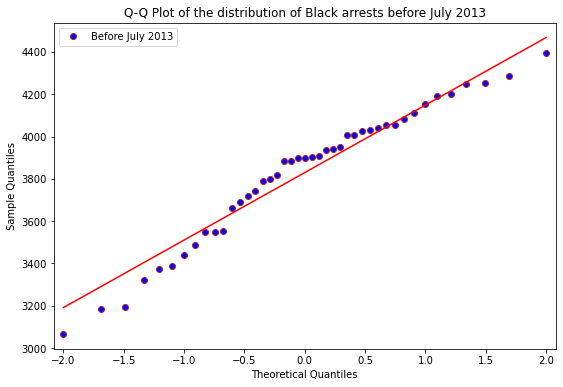

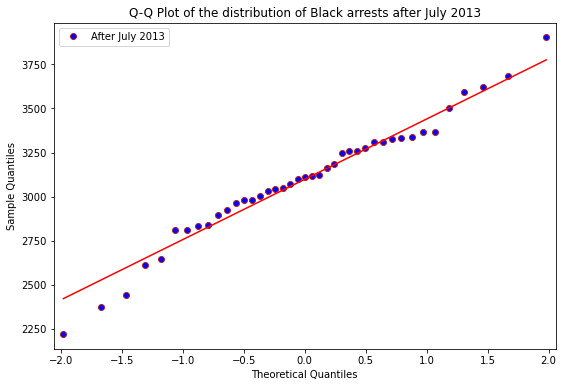

Variance of the arrests distribution before July 2013: 104195.052
Variance of the arrests distribution after July 2013: 119986.289 


In [10]:
checking_normality_variance(black_trends_before, black_trends_after, 'Black')

Looking at the Q-Q plot, both distributions (before and after July 2013) seem to be normal. 

The variances are not exactly equal (it was indeed highly improbable). 

Since our distributions are normally distributed but the variances are unequal, we will perform a Welch's t-test to compare the means of the two distributions.

We test the following hypothesis:

- Null hypothesis: $(H_0)$ : $\mu_1$ = $\mu_2$ (the means of both samples are equal)
- Alternative hypothesis: $(H_A)$: $\mu_1\neq \mu_2$ (the mean of sample 1 is not equal to the mean of sample 2).


In [11]:
display(stats.ttest_ind(black_trends_before['Arrestations'], black_trends_after['Arrestations'], equal_var = False))

Ttest_indResult(statistic=10.001206597811658, pvalue=8.589682236410346e-16)

Since the p-value is very small (smaller than 0.05), we can reject the null hypothesis being that the average monthly arrests are equal before and after the apparition of the Black Lives Matter movement.

Thus we can conclude that there is indeed a significant diminution of African American arrests after July 2013.

### 1.3. Segmented regression analysis

To better analyse the arrests trends per month, a model-based empirical analysis is required. To do so, a segmented regression analysis is performed. We will perform the segmented regression of the data obtained with July 2013 (date of the creation of the Black Lives Matter movement) as the "interruption" element.

#### Regression analysis visualization

We will start by visualizing this regression analysis.

In [12]:
black_trends = pd.concat([black_trends_before, black_trends_after]).reset_index(drop = True)
black_trends['Time'] = black_trends.index + 1

**Remark :** The first step is to prepare the dataset that will be used for the visualization. We use the above created dataframes (`black_trends_before` and `balck_trends_after`) that contains the number of arrests of African Americans aggregated by months and the parameter `Period`, used to label the data (to distinguish between arrests before and after July 2013).

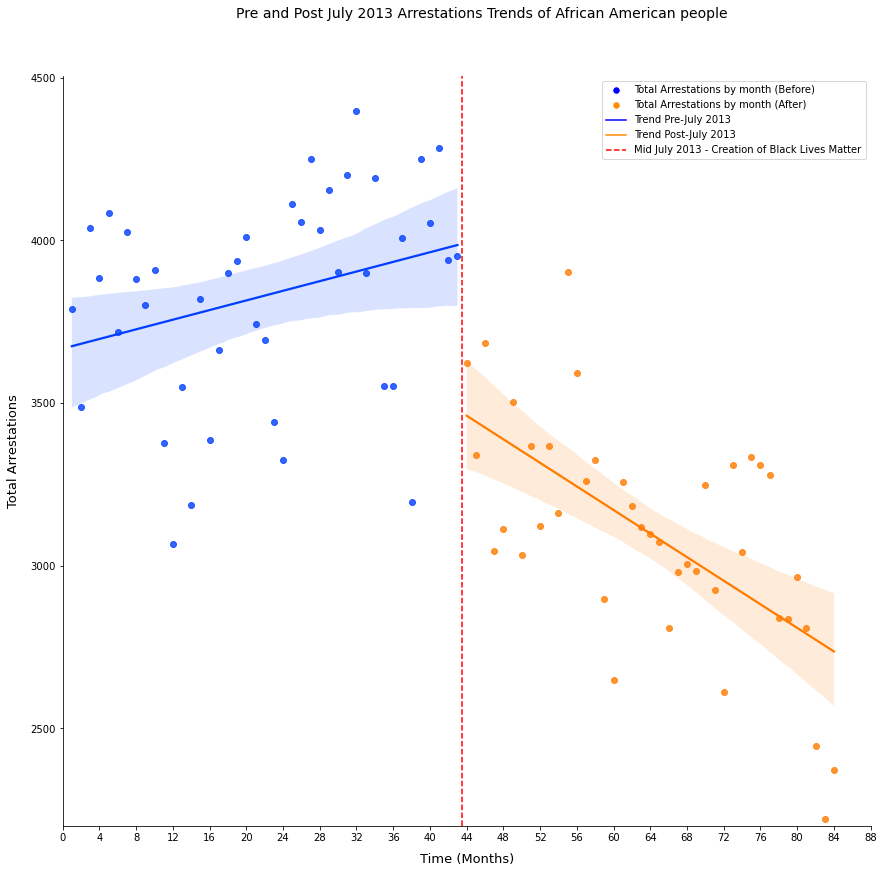

In [13]:
#Showing the results of the segmented linear regression
ax = sns.lmplot(x="Time", y="Arrestations", hue = "Period", data=black_trends, ci=95, palette="bright", height = 12)
ax._legend.remove()
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Pre and Post July 2013 Arrestations Trends of African American people', fontsize = 14)
ax.set_axis_labels("Time (Months)", "Total Arrestations", fontsize = 13, labelpad = 10)
plt.axvline(x = 43.5, color = 'red', alpha = 2, linestyle = '--')
plt.xlim(0, 86)
plt.ylim(2200, None)
ax.set(xticks = range(0, 92, 4))

#Constructing the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Total Arrestations by month (Before)', markerfacecolor='blue', markersize=7.5),
                   Line2D([0], [0], marker='o', color='w', label='Total Arrestations by month (After)', markerfacecolor='darkorange', markersize=7.5),
                   Line2D([0], [0], color='blue', label = "Trend Pre-July 2013"), 
                   Line2D([0], [0], color='darkorange', label = "Trend Post-July 2013"), 
                   Line2D([0], [0], color='red', linestyle = '--', alpha = 2 , label = "Mid July 2013 - Creation of Black Lives Matter")]

plt.legend(handles=legend_elements)


plt.show()

This graph includes the trend of the results of the regression analysis and a scatter plot of the data.

In this graph, one can observe a large and immediate drop in the number of arrests right after the creation of the movement. A large difference in the trend of the data can also be observed. From these observations it seems that the creation of the Black Lives Matter movement affected the trend of arrestations of African Americans in L.A..

Let's support these findings with numerical results.

#### Numerical Segmented regression

The equation of a segment regression analysis can be seen as follow:

$Y_{t} = \beta_{0} + \beta_{1}\times time + \beta_{2}\times intervention +  \beta_{3}\times postslope + \epsilon_{1}^{111}  $ 

In our case, the varialbe $Y_{t}$ is the monthly aggregate of the arrests of African American people. 

Let's clarify the meaning of the parameters in the above-mentioned equation:

- $\beta_{0}$ represents the baseline level of $Y_t$ at the beginning of the study (meaning, the total number of arrests during the first month)
- $\beta_{1}$ represents the slope of the trend independently from the intervention event (meaning the growh rate of the arrests of African Americans independently from the creation of Black Lives Matter)
- $\beta_{2}$ represents the change in the number of arrests; it measures and represents the effect of the intervention event (i.e. the Black Lives Matter creation)
- $\beta_{3}$ represents the change in the overall trend after the event. It is used to assess whether there is a raise or a decline in the number of arrests of African Americans



In [14]:
def segmented_regression(df):
    data_regression = df.copy()
    data_regression['x2'] = data_regression['Period'].apply(lambda x : 0 if x == 'Before' else 1)
    data_regression['x3'] = data_regression['Time'].apply(lambda x : x-43 if x>43 else 0)
    y_df = data_regression['Arrestations']
    data_regression = data_regression.drop(columns = ['Arrestations','Period']).rename(columns = {'Time':'x1'})

    X_df = data_regression
    X_df = sm.add_constant(X_df.values)
    model = sm.OLS(y_df, X_df).fit()
    display(model.summary(xname = ["intercept","time", "intervention", "postslope"]))

**Remark:** We define a function `segmented_regression` to perform the semgented regression in a more automatized way. The function starts by creating the table used for the regression. The table contains the three variables that are needed to perform the segmented regression analysis that follows the equation presented above. In our case, the column `x1` of the dataframe corresponds to the variable $\text{time}$ of the equation, the column `x2` corresponds to the variable $\text{intervention}$ and the column `x3` corresponds to the variable $\text{postslope}$. Once the table is formed, the function fits the regression model and displays the summary of the regression.

In [15]:
segmented_regression(black_trends)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Arrestations   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     51.87
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.01e-18
Time:                        12:03:56   Log-Likelihood:                -594.65
No. Observations:                  84   AIC:                             1197.
Df Residuals:                      80   BIC:                             1207.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     3666.8372     91.349     40.141      0.000    3485.048    3848.627
time             7.4049      3.617      2.048      0.044       0.208      14.602
intervention  -506.5804    128.642     -3.938      0.000    -762.587    -250.574
postslope      -25.5202      5.307     -4.808      0.000     -36.082     -14.958
==============================================================================
Omnibus:                        2.788   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.248   Jarque-Bera (JB):                2.733
Skew:                          -0.427   Prob(JB):                        0.255
Kurtosis:                       2.772   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When analyzing this regression table, one can observe that all p-values are smaller than 0.05, proving a significant importance of these variables. Most importantly, the variable `intervention` has a p-value at 0.000, showing that the intervention has a significant effect. One can also notice the difference in the coefficient of the variables `time` and `postslope` (respectively at 7.4049 and -25.5202). These data reinforce what has been visualized in the above graph: before July 2013, the number of arrests of African Americans was increasing each month; after July 2013, the number of arrests is decreasing each months. The intervention event in July 2013 has therefore given rise to a change in the tendency of the arrests of African American people in L.A..

---

## Question 2

### _How does the evolution of the trend of arrests of the other races differ from those of the African Americans ?_

In the first part of our analysis, we found a decrease in the overall number of arrests of African Americans after July 2013, date of the creation of the Black Lives Matter movement. To ensure that this reduction is linked with this disruptive event, a control group should be added to the analysis. 

We will study the impact of the intervention event on the arrests of White and Hispanic people (the two other races with the most arrests). 

### 2.1. Evolution of white people arrests

#### 2.1.1. Non-model empirical findings

As for the analysis of African Americans, we begin with a non-model analysis.

Let's start by preparing the data to analyse the arrestations of white people.

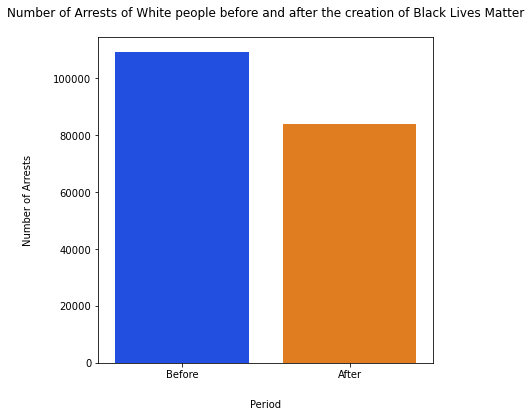

In [16]:
white_data = race_data[race_data['Race'] == 'W']
white_before_movement = white_data[white_data['Date'] < movement_creation_date].assign(Period = "Before")
white_after_movement = white_data[(white_data['Date'] >= movement_creation_date) & 
                                  (white_data['Date'] <= datetime.datetime(2016,12,31))].assign(Period = "After")

fig = plt.figure(figsize=(6,6))
ax = plot = sns.countplot(x='Period', data= pd.concat([white_before_movement, white_after_movement]), palette = 'bright')
plt.title("Number of Arrests of White people before and after the creation of Black Lives Matter", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Period', labelpad = 20)
plt.show()

In [17]:
print('Number of Arrests Before : ' + str(len(white_before_movement)))
print('Number of Arrests After  : ' + str(len(white_after_movement)))
print('Decrease percentage : ' + str(round((len(white_before_movement)- len(white_after_movement))/len(white_before_movement)*100,2)) + "%")

Number of Arrests Before : 109194
Number of Arrests After  : 84031
Decrease percentage : 23.04%


One can observe a similar decrease in the number of arrests. Let's support this observation with a statistical comparison of means. We first need to assess that the data obtained are normally distributed and check if they have equal variance.

In [18]:
white_trends_before = white_before_movement.set_index('Date') \
                        .replace('W', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'Before')

white_trends_after = white_after_movement.set_index('Date') \
                        .replace('W', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'After')

**Remark:** Here, the number of arrests of White people are aggregated by months. A label (represented by the variable `Period`) is also added to discriminate between the arrestations that occured before July 2013 and the ones that occured after July 2013. 

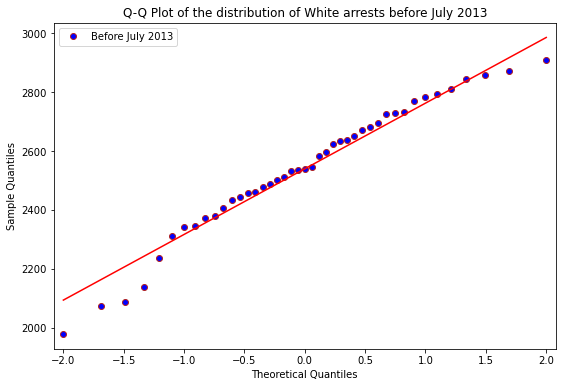

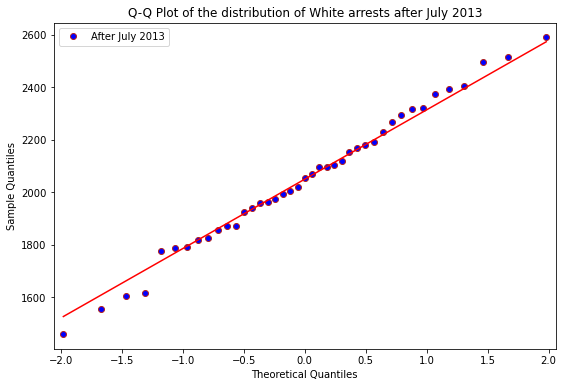

Variance of the arrests distribution before July 2013: 50951.959
Variance of the arrests distribution after July 2013: 71479.905 


In [19]:
checking_normality_variance(white_trends_before, white_trends_after, 'White')

One can observe in the QQ-plot presented above that both group seems to follow a normal distribution (there is a small deviation at the tails but it does not appear to be a large violation). 

When comparing the variance of both groups, we can observe a significant difference. 

Since the equality of variance is not respected, the student t-test can not be performed to compare the means of both groups. The Welch's t-test is therefore used, with the same hypothesis that have been presented above. 

In [20]:
stats.ttest_ind(white_trends_before['Arrestations'], white_trends_after['Arrestations'], equal_var = False)

Ttest_indResult(statistic=9.052322415941997, pvalue=8.21312025776785e-14)

The p-value is less than 0.05 and therefore we reject the null hypothesis. We can then affirm that the mean arrests of white people before July 2013 is statistically different from the mean arrests after July 2013. 

#### 2.1.2. Regression analysis visualization

Let's visualize the regression analysis to have a better insight.

In [21]:
white_trends = pd.concat([white_trends_before, white_trends_after]).reset_index(drop = True)
white_trends['Time'] = white_trends.index + 1

**Remark:** To plot the regression, we create a dataset that contains the arrests of both black and white people. A `label_values` function is defined to set labels to the obtained data. It will be used to discriminate between arrests of white and black people, before and after July 2013.

In [22]:
def label_values(x):
    if x <= 42:
        return 'Trend of black arrests before July 2013'
    elif x <= 83:
        return 'Trend of black arrests after July 2013'
    elif x <= 126:
        return 'Trend of white arrests before July 2013'
    else:
        return 'Trend of white arrests after July 2013'

In [23]:
w_b_trends = black_trends.copy()
w_b_trends = w_b_trends.append(white_trends)
w_b_trends.reset_index(inplace = True)

#Defining the labels
w_b_trends['Label'] = w_b_trends.index.values
w_b_trends['Label'] = w_b_trends['Label'].apply(label_values)

In [24]:
def plot_control_regression(df, race):
    ax = sns.lmplot(x="Time", y="Arrestations", hue = "Label", data=df, ci=95, palette="bright", height = 12)
    ax._legend.remove()
    plt.subplots_adjust(top=0.9)
    ax.fig.suptitle('Pre and Post July 2013 Arrestations Trends of African American and White people', fontsize = 14)
    ax.set_axis_labels("Time (Months)", "Total Arrestations", fontsize = 13, labelpad = 10)
    plt.axvline(x = 43.5, color = 'red', alpha = 2, linestyle = '--')
    plt.xlim(0, 86)
    plt.ylim(1000, None)
    ax.set(xticks = range(0, 92, 4))

    #Constructing the legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Total Arrestations of Black people by month (Before)', markerfacecolor='blue', markersize=7.5),
                       Line2D([0], [0], marker='o', color='w', label='Total Arrestations of Black people month (After)', markerfacecolor='darkorange', markersize=7.5),
                       Line2D([0], [0], marker='o', color='w', label='Total Arrestations of ' + race + ' people by month (Before)', markerfacecolor='green', markersize=7.5),
                       Line2D([0], [0], marker='o', color='w', label='Total Arrestations of ' + race + ' people by month (After)', markerfacecolor='red', markersize=7.5),
                       Line2D([0], [0], color='blue', label = "Trend of Black Arrests Pre-June 2013"), 
                       Line2D([0], [0], color='darkorange', label = "Trend of Black Arrests Post-June 2013"), 
                       Line2D([0], [0], color='green', label = 'Trend of ' + race + ' Arrests Pre-June 2013'), 
                       Line2D([0], [0], color='red', label = 'Trend of ' + race + ' Arrests Post-June 2013'), 
                       Line2D([0], [0], color='red', linestyle = '--', alpha = 2 , label = "Mid July 2013 - Creation of Black Lives Matter")]

    plt.legend(handles=legend_elements)


    plt.show()
    

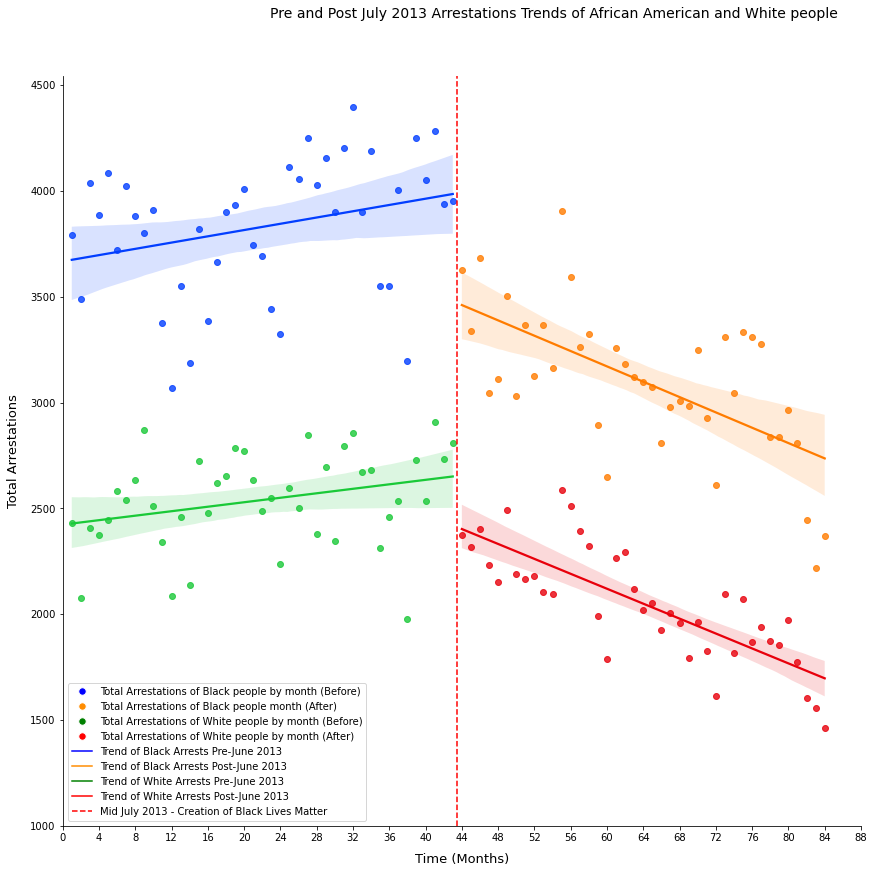

In [25]:
plot_control_regression(w_b_trends, 'White')

As before, the graph of the segmented regression analysis includes the trend of the results of the analysis and a scatter plot of the data. This graph represents the trend of arrests of Black people and the trend of arrests of White people.

In this graph, one can observe a similar trend for the arrest of white and black people after July 2013. These findings are unconsistents with our hypothesis. Indeed, the Black Lives Matter movement aims at eradicating white supremacy. Thus, the creation of the movement should not influence the arrestation trend of white people. 

Before concluding, let's perform a numerical segmented regression.

#### 2.1.3. Numerical Segmented regression

Here, we apply a similar method to the one used to perform the numerical segment regression for black people arrests.

In [26]:
segmented_regression(white_trends)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Arrestations   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     61.69
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           9.34e-21
Time:                        12:03:58   Log-Likelihood:                -559.89
No. Observations:                  84   AIC:                             1128.
Df Residuals:                      80   BIC:                             1138.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     2422.9402     60.394     40.119      0.000    2302.752    2543.129
time             5.2934      2.391      2.214      0.030       0.535      10.052
intervention  -230.6998     85.051     -2.712      0.008    -399.956     -61.443
postslope      -22.9277      3.509     -6.534      0.000     -29.911     -15.945
==============================================================================
Omnibus:                        4.862   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.090
Skew:                          -0.471   Prob(JB):                        0.129
Kurtosis:                       3.531   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These results show also a reduction in the trend of arrests of white people after July 2013. Indeed, one can observe that all p-values are smaller than 0.05, proving a significant importance of these variables. The variable `intervention` has a p-value at 0.008, showing that the intervention has a significant effect. The coefficient of the variables `time` and `postslope` are also of interest: they are respectively at 5.2934 and at -22.9277, reinforcing the graphical observations. 

These findings are quite unexpected. Indeed, as presented earlier, the creation of the Black Lives Matter movement should not impact so much the arrests of White people. Whith a closer look on the political history of L.A. we found that in July 2013, Eric Marcetti began his term as L.A. mayer. Mayor Garcetti aimed at making L.A. a safer place. This could explain the overall decrease in arrestations (across all races) after July 2013.

----

### 2.2 Hispanics as a control group

We will now study the effect of the creation of Black Lives Matter movement on the arrestations of hispanic people.

#### 2.2.1. Non-model empirical findings

We also want to analyse the evolution of hispanic arrest as it could be either a control group or a population that has been positively impacted by the creation of the movement.

Like before, we first look at the number of arrests before and after July 2013.

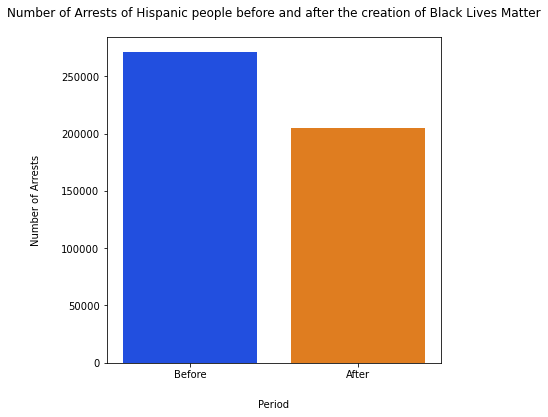

In [27]:
hispanic_data = race_data[race_data['Race'] == 'H']
hispanic_before_movement = hispanic_data[hispanic_data['Date'] < movement_creation_date].assign(Period = "Before")
hispanic_after_movement = hispanic_data[(hispanic_data['Date'] >= movement_creation_date) & 
                                  (hispanic_data['Date'] <= datetime.datetime(2016,12,31))].assign(Period = "After")

fig = plt.figure(figsize=(6,6))
ax = plot = sns.countplot(x='Period', data= pd.concat([hispanic_before_movement, hispanic_after_movement]), palette = 'bright')
plt.title("Number of Arrests of Hispanic people before and after the creation of Black Lives Matter", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Period', labelpad = 20)
plt.show()

One can observe with this barplot a decrease in the number of arrests of Hispanics after July 2013.

Once again, let's assess if there is a significant decrease. We begin by checking the normality and equality of variance to perform a statistical comparison of means.

In [28]:
hispanic_trends_before = hispanic_before_movement.set_index('Date') \
                        .replace('H', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'Before')

hispanic_trends_after = hispanic_after_movement.set_index('Date') \
                        .replace('H', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'After')

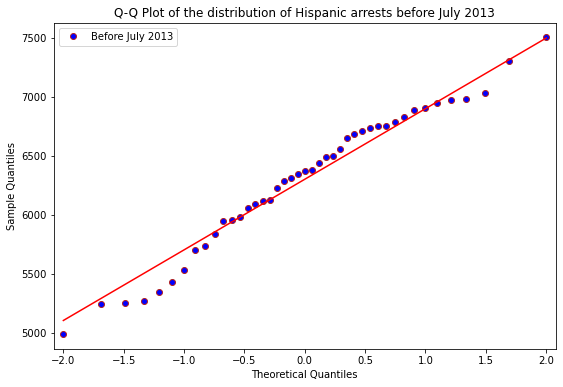

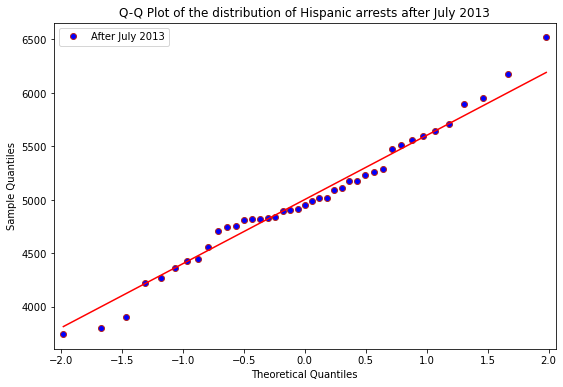

Variance of the arrests distribution before July 2013: 366311.086
Variance of the arrests distribution after July 2013: 368713.495 


In [29]:
checking_normality_variance(hispanic_trends_before, hispanic_trends_after, 'Hispanic')

In the above graphs, we can observe that our groups are normally distributed. Also, the variance seem to be equal. We can therefore use the Student t-test to compare the two means. The Student t-test has the same hypothesis as the Welch's t-test:

- Null hypothesis: $(H_0)$ : $\mu_1$ = $\mu_2$ (the means of both samples are equal)
- Alternative hypothesis: $(H_A)$: $\mu_1\neq \mu_2$ (the mean of sample 1 is not equal to the mean of sample 2).


In [30]:
stats.ttest_ind(white_trends_before['Arrestations'], white_trends_after['Arrestations'], equal_var = True)

Ttest_indResult(statistic=9.088976915303657, pvalue=4.7879146577932597e-14)

Here, we find a p-value that is lower thant 0.05. We can therefore reject the null hypothesis: the mean arrests of Hispanics before July 2013 is therefore significantly different from the mean arrests of Hispanics after July 2013.

#### 2.2.2. Regression analysis visualisation

In [31]:
hispanic_trends = pd.concat([hispanic_trends_before, hispanic_trends_after]).reset_index(drop = True)
hispanic_trends['Time'] = hispanic_trends.index + 1

In [32]:
h_w_trends = black_trends.copy()
h_w_trends = h_w_trends.append(hispanic_trends)
h_w_trends.reset_index(inplace = True)

#Defining the labels
h_w_trends['Label'] = h_w_trends.index.values
h_w_trends['Label'] = h_w_trends['Label'].apply(label_values)

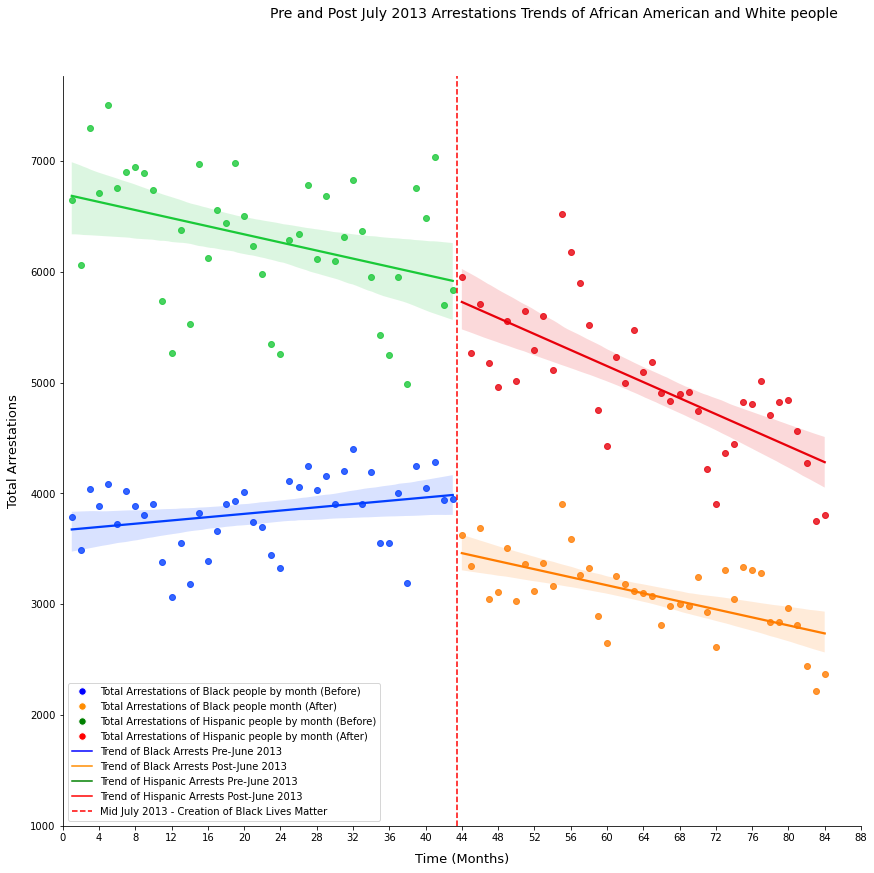

In [33]:
plot_control_regression(h_w_trends, 'Hispanic')

Once can observe that the trend of the arrests of Hispanic people is quite similar before and after July 2013. Let's investigate further this observation with numerical data.

#### 2.2.3. Numerical Segmented regression

In [34]:
segmented_regression(hispanic_trends)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Arrestations   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     58.75
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           3.60e-20
Time:                        12:04:01   Log-Likelihood:                -640.05
No. Observations:                  84   AIC:                             1288.
Df Residuals:                      80   BIC:                             1298.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     6702.7143    156.844     42.735      0.000    6390.586    7014.843
time           -18.2640      6.209     -2.941      0.004     -30.621      -5.907
intervention  -154.1892    220.876     -0.698      0.487    -593.747     285.369
postslope      -17.8791      9.113     -1.962      0.053     -36.014       0.256
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   1.409
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.514
Skew:                          -0.184   Prob(JB):                        0.773
Kurtosis:                       2.893   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When analyzing this regression table, one can observe that only the p-value of the varialbe `time` is smaller than 0.05. The p-value for the variable `intervention` is at 0.487, suggesting that the intervention has not a significant effect. Moreover, we can observe that the coefficient $\beta_1$ (corresponding to the trend of arrests of Hispanic before the intervention) and the coefficient $\beta_3$ (corresponding to the trend after the intervention) are quite similar (respectively -18.2640 and -17.8791). These results supports our graphical observations: the intervention does not impact the evolution of arrests of Hispanics.


### 2.2 Control group with both Whites and Hispanics

---

## Question 3
### _Is there a difference in the number of arrestations between males and females African Americans ? What about after the Black Lives Matter movement ?_

### 3.1. Comparisons of number of arrests

As a first insight, we compare the number of arrests of back men with the number of arrests of black women.

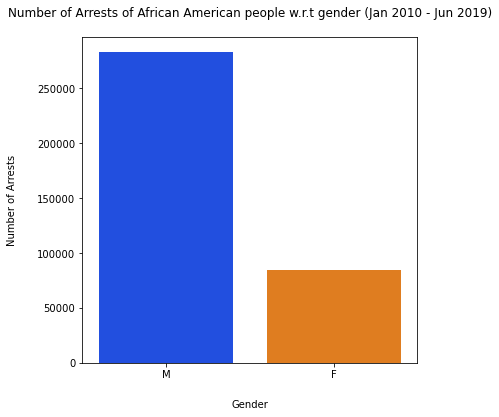

In [35]:
gender_black_data = arrest_data[arrest_data['Race'] == 'B'][['Date', 'Gender']].reset_index(drop = True)

fig = plt.figure(figsize=(6,6))
ax = plot = sns.countplot(x='Gender', data=gender_black_data, palette = 'bright')
plt.title("Number of Arrests of African American people w.r.t gender (Jan 2010 - Jun 2019)", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Gender', labelpad = 20)
plt.show()

This shows us how men and women are not equal here. (peut être calculer un ratio ?)

We now want to look at the evolution of the number of arrests for both sex separetely. 

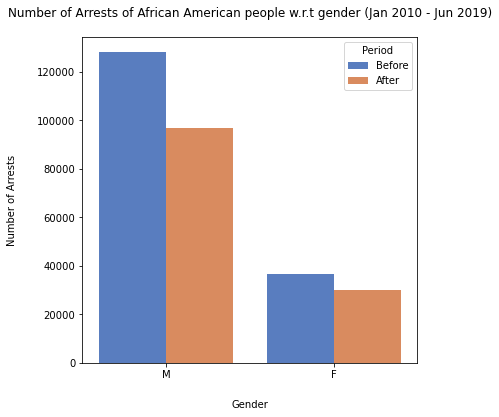

In [36]:
gender_black_data['Period'] = gender_black_data['Date'].apply(lambda x: 'Before' if x <= movement_creation_date else 'After')
gender_black_data = gender_black_data[gender_black_data['Date'] <= datetime.datetime(2016,12,31)].reset_index(drop = True).sort_values(by='Date')

fig = plt.figure(figsize=(6,6))
ax = plot = sns.countplot(x='Gender', hue = 'Period',data=gender_black_data, palette = 'muted')
plt.title("Number of Arrests of African American people w.r.t gender (Jan 2010 - Jun 2019)", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Gender', labelpad = 20)
plt.show()

### TO ADD: ratio before and after

### 3.2. Segmented regression analysis

We perform a segmented regression analysis for both sex separately to observe if the changes in trends are observable for men and women identically or if there are divergences.

#### 3.2.1. Regression analysis visualisation

In [37]:
female_black_data = gender_black_data[gender_black_data['Gender'] == 'F'] \
                    .set_index('Date') \
                    .replace('F', 1) \
                    .rename(columns = {'Gender' : 'Arrestations'}) \
                    .groupby(pd.Grouper(freq = 'M')).sum() \
                    .reset_index() \
                    .sort_values(by = 'Date')

female_black_data_before = female_black_data[female_black_data['Date'] < datetime.datetime(2013, 8, 1)] \
                            .assign(Period = 'Before Female') \
                            .assign(Time = lambda x : x.index + 1)

female_black_data_after = female_black_data[female_black_data['Date'] >= datetime.datetime(2013, 8, 1)] \
                            .assign(Period = 'After Female') \
                            .assign(Time = lambda x : x.index + 1)


male_black_data = gender_black_data[gender_black_data['Gender'] == 'M'] \
                    .set_index('Date') \
                    .replace('M', 1) \
                    .rename(columns = {'Gender' : 'Arrestations'}) \
                    .groupby(pd.Grouper(freq = 'M')).sum() \
                    .reset_index() \
                    .sort_values(by = 'Date')

male_black_data_before = male_black_data[male_black_data['Date'] < datetime.datetime(2013, 8, 1)] \
                            .assign(Period = 'Before Male') \
                            .assign(Time = lambda x : x.index + 1)

male_black_data_after = male_black_data[male_black_data['Date'] >= datetime.datetime(2013, 8, 1)] \
                            .assign(Period = 'After Male') \
                            .assign(Time = lambda x : x.index + 1)

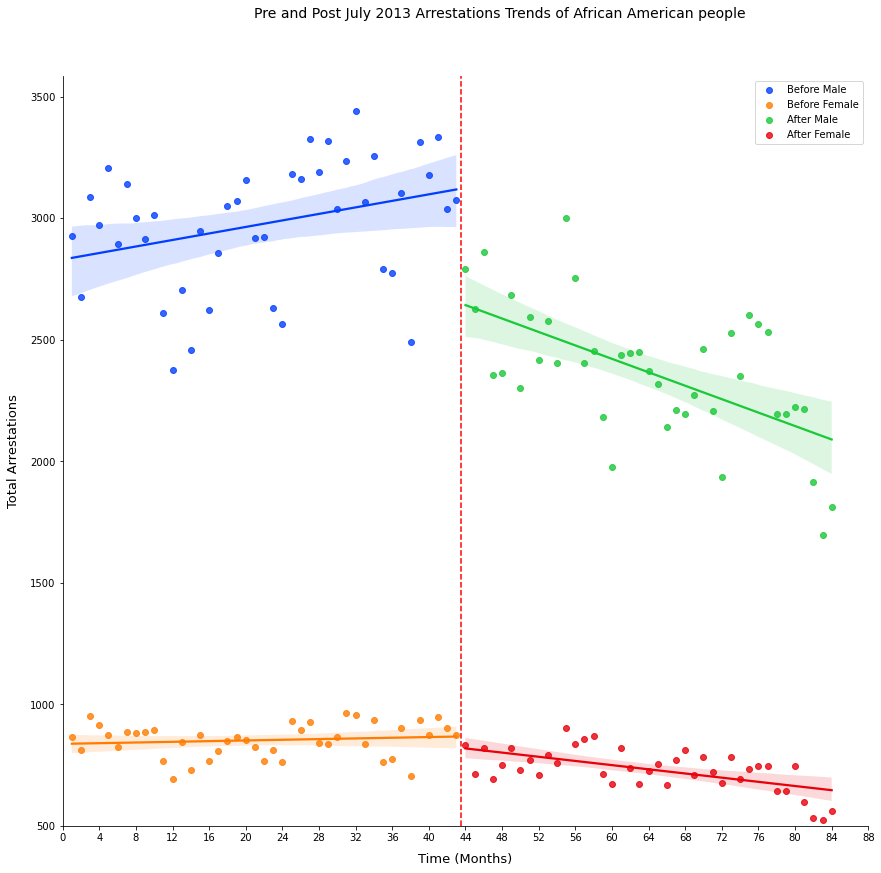

In [38]:
ax = sns.lmplot(x="Time", y="Arrestations", hue = "Period", data=pd.concat([male_black_data_before, female_black_data_before, male_black_data_after, female_black_data_after]),
                ci=95, palette="bright", height = 12)

plt.subplots_adjust(top=0.9)
ax._legend.remove()
ax.fig.suptitle('Pre and Post July 2013 Arrestations Trends of African American people', fontsize = 14)
ax.set_axis_labels("Time (Months)", "Total Arrestations", fontsize = 13, labelpad = 10)
plt.axvline(x = 43.5, color = 'red', alpha = 2, linestyle = '--')
plt.xlim(0, 86)
plt.ylim(500, None)
ax.set(xticks = range(0, 92, 4))

plt.legend()


plt.show()

### TO ADD: conclusion

#### 3.2.2. Numerical Segmented regression

_Male Segmented regression_

In [39]:
male_trends = pd.concat([male_black_data_before, male_black_data_after])
male_trends['x2'] = male_trends.Period.apply(lambda x : 0 if x=='Before Male' else 1)
male_trends['x3'] = male_trends.Time.apply(lambda x: x-43 if x>43 else 0)
y_df = male_trends['Arrestations']
male_trends = male_trends.drop(columns = ['Date', 'Period', 'Arrestations']).rename(columns = {'Time':'x1'})

In [40]:
X_df = male_trends
X_df = sm.add_constant(X_df.values)
model = sm.OLS(y_df, X_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Arrestations   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     54.80
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           2.37e-19
Time:                        12:04:06   Log-Likelihood:                -576.49
No. Observations:                  84   AIC:                             1161.
Df Residuals:                      80   BIC:                             1171.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2829.7342     73.587     38.454      0.000    2683.291    2976.178
x1             6.7045      2.913      2.301      0.024       0.907      12.502
x2          -461.9618    103.630     -4.458      0.000    -668.192    -255.731
x3           -20.5252      4.275     -4.801      0.000     -29.034     -12.017
==============================================================================
Omnibus:                        2.144   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                2.138
Skew:                          -0.366   Prob(JB):                        0.343
Kurtosis:                       2.727   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### TO ADD: conclusion

_Female Segmented regression_

In [41]:
female_trends = pd.concat([female_black_data_before, female_black_data_after])
female_trends['x2'] = female_trends.Period.apply(lambda x : 0 if x=='Before Female' else 1)
female_trends['x3'] = female_trends.Time.apply(lambda x: x-43 if x>43 else 0)
y_df = female_trends['Arrestations']
female_trends = female_trends.drop(columns = ['Date', 'Period', 'Arrestations']).rename(columns = {'Time':'x1'})

In [42]:
X_df = female_trends
X_df = sm.add_constant(X_df.values)
model = sm.OLS(y_df, X_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Arrestations   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     28.21
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.51e-12
Time:                        12:04:06   Log-Likelihood:                -473.72
No. Observations:                  84   AIC:                             955.4
Df Residuals:                      80   BIC:                             965.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        837.1030     21.651     38.663      0.000     794.016     880.190
x1             0.7004      0.857      0.817      0.416      -1.005       2.406
x2           -44.6187     30.491     -1.463      0.147    -105.297      16.060
x3            -4.9950      1.258     -3.971      0.000      -7.498      -2.492
==============================================================================
Omnibus:                        3.777   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                2.715
Skew:                          -0.284   Prob(JB):                        0.257
Kurtosis:                       2.326   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### TO ADD: conclusion

---

## Conclusion

### TO ADD